# Convolutional Autoencoder with K-Means

In [31]:
import torch
import numpy as np
from torchvision import datasets
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time

# to import MNIST as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

## training and testing dataloaders

In [2]:
num_workers = 0
# how many samples per batch to load
batch_size = 100
lr = 1e-3
# how many epochs for training
num_epochs = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

## autoencoder neural network design
* input layer: 1 channel, 28 pixels wide, 28 pixels long
* conv 1 layer: 16 channel, 10 pixels wide, 10 pixels long
* pool 1 layer: 16 channel, 5 pixels wide, 5 pixels long
* conv 2 layer: 32 channel, 3 pixels wide, 3 pixels long
* pool 2 layer: 32 channel, 2 pixels wide, 2 pixels long

* latent layer: 128 input, 10 output
* upscale layer: 10 input, 128 output

* deconv 3 layer: 16 channel, 5 pixels wide, 5 pixels long
* deconv 2 layer: 8 channel, 15 pixels wide, 15 pixels long
* deconv 1 layer: 1 channel, 28 pixels wide, 28 pixels long

In [3]:
class cae(nn.Module):
    def __init__(self):
        super(cae, self).__init__()
        # convolutional encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # 16, 5, 5
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 32, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # 32, 2, 2
        )
        # autoencoder bottle neck
        self.latent = nn.Sequential(
            nn.Linear(32*2*2, 10),
            #nn.Sigmoid()
        )
        self.upscale = nn.Sequential(
            nn.Linear(10, 32*2*2),
            nn.ReLU(True),
        )
        # convolutional decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2),  # 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 1, 28, 28
            nn.Tanh()
        )
    # forward learning path
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x.view(-1, 32*2*2))
        
        bottle_neck = torch.sigmoid(x)
        x = torch.tanh(x)
        
        x = self.upscale(x)
        x = self.decoder(x.view(-1, 32, 2, 2))
        return x, bottle_neck

## CAE model instantiation

In [4]:
# build a CAE model
model = cae()
# set loss function
criterion = nn.MSELoss()
# choose an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr,
                             weight_decay=1e-7)
print(model)

cae(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (latent): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
  (upscale): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


## training

In [5]:
t_error = []
t_error_ = []
v_error = []
# Training the model
for epoch in range(num_epochs):
    for batch_index, data in enumerate(train_loader):
        if (batch_index+1)%10 != 0:
            img, _ = data
            # forward path
            output, _ = model(img)
            loss = criterion(output, img)
            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t_error_.append(loss.item())
        else:
            t_error.append(sum(t_error_)/len(t_error_))
            t_error_ = []
            with torch.no_grad():
                model.eval()
                output, _ = model(img)
                v_error.append(F.mse_loss(output, img).item())
                model.train()
    # log
    print('epoch [{}/{}], loss:{:.4f}, valid:{:.4f}'
          .format(epoch+1, num_epochs, loss.item(), v_error[-1]))

epoch [1/20], loss:0.0443, valid:0.0436
epoch [2/20], loss:0.0313, valid:0.0314
epoch [3/20], loss:0.0273, valid:0.0273
epoch [4/20], loss:0.0256, valid:0.0255
epoch [5/20], loss:0.0246, valid:0.0246
epoch [6/20], loss:0.0240, valid:0.0240
epoch [7/20], loss:0.0235, valid:0.0235
epoch [8/20], loss:0.0231, valid:0.0231
epoch [9/20], loss:0.0227, valid:0.0227
epoch [10/20], loss:0.0225, valid:0.0223
epoch [11/20], loss:0.0220, valid:0.0218
epoch [12/20], loss:0.0217, valid:0.0216
epoch [13/20], loss:0.0216, valid:0.0214
epoch [14/20], loss:0.0214, valid:0.0212
epoch [15/20], loss:0.0212, valid:0.0210
epoch [16/20], loss:0.0211, valid:0.0209
epoch [17/20], loss:0.0209, valid:0.0208
epoch [18/20], loss:0.0207, valid:0.0206
epoch [19/20], loss:0.0207, valid:0.0206
epoch [20/20], loss:0.0205, valid:0.0205


## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

In [6]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()
model.eval()

# get sample outputs
with torch.no_grad():
    output, _ = model(images)
# prep images for display
images = images.numpy()# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

<Figure size 2500x400 with 20 Axes>

## reconstruct the train dataset

In [7]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(train_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded = encoded.detach().numpy()
        #first group decoded
        disembedded = decoded.detach().numpy()
        #labels
        labels = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded = np.vstack((embedded, encoded.detach().numpy()))
    disembedded = np.vstack((disembedded, decoded.detach().numpy()))
    labels = np.hstack((labels, itr_labels.detach().numpy()))

## clustering model instantiation and training

In [8]:
from sklearn.cluster import KMeans

# create a k-means model to cluster the embedded features
clustering_model = KMeans(n_clusters=10, tol = 1e-4, max_iter = 400).fit(embedded)

## visualizing results and performance evaluation

### testing autoencoder

In [9]:
# run the dataset through the trained model
model.eval()
for image_index, data in enumerate(test_loader):
    images, itr_labels = data
    # forward pass: compute embedded outputs by passing inputs to the model
    decoded, encoded = model(images)
    if not image_index:
        #First group encoded in new array
        embedded_test = encoded.detach().numpy()
        #first group decoded
        disembedded_test = decoded.detach().numpy()
        #labels
        labels_test = itr_labels.detach().numpy()
        continue
    #stacking the remaining data
    embedded_test = np.vstack((embedded_test, encoded.detach().numpy()))
    disembedded_test = np.vstack((disembedded_test, decoded.detach().numpy()))
    labels_test = np.hstack((labels_test, itr_labels.detach().numpy()))

In [10]:
labels_pred = clustering_model.predict(embedded_test)

In [11]:
import import_ipynb
import DataVisuals as dv


view_results = dv.DataVisuals(disembedded.reshape(-1, 28,28), labels, clustering_model.labels_)
view_results_test = dv.DataVisuals(disembedded_test.reshape(-1, 28,28), labels_test, labels_pred)

importing Jupyter notebook from DataVisuals.ipynb


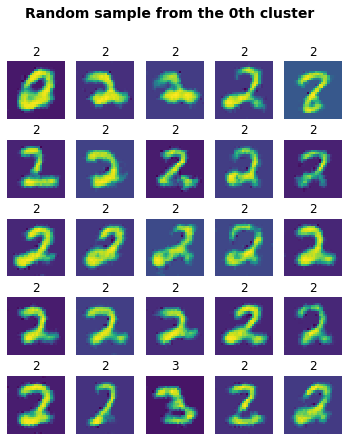

In [12]:
#view reconstructed random samples belonging to the same cluster
view_results.view_lblsample(0)

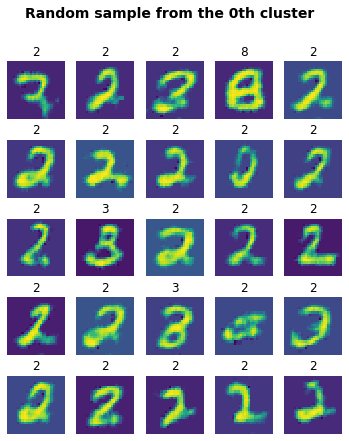

In [13]:
# test data
view_results_test.view_lblsample(0)

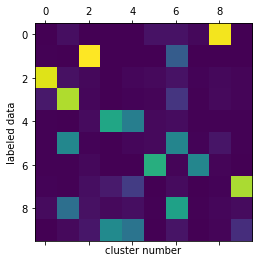

In [14]:
view_results.cm()

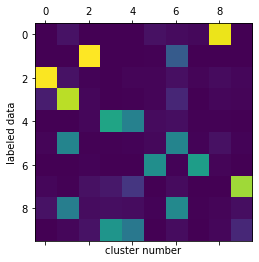

In [15]:
view_results_test.cm()

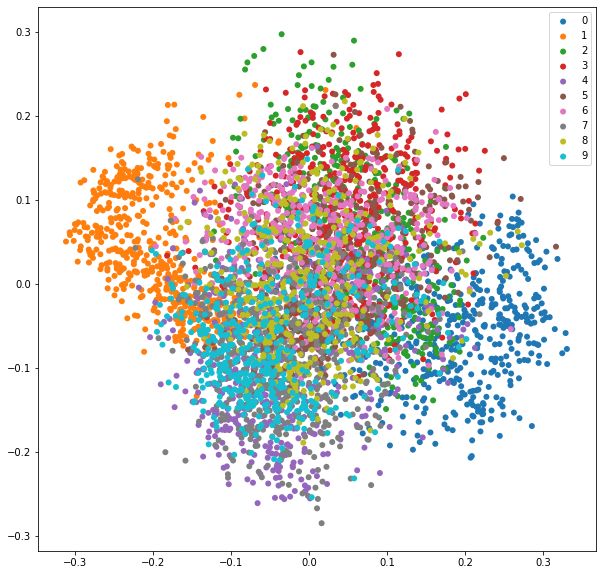

In [16]:
view_results.scat(embedded)

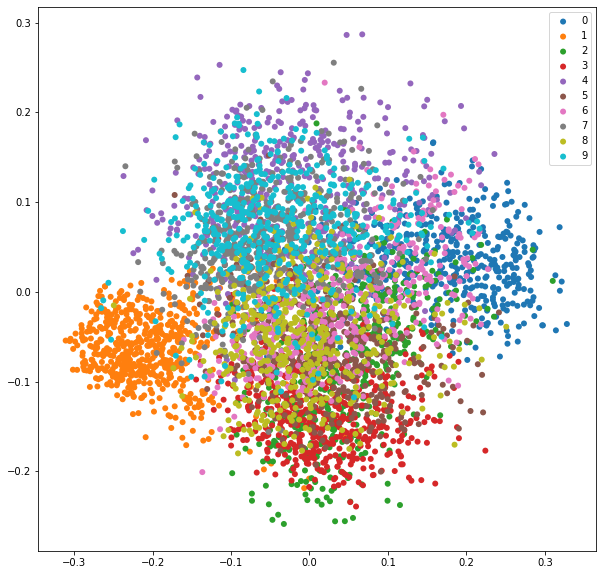

In [17]:
view_results_test.scat(embedded_test)

In [18]:
metric = dv.Metrics(labels, clustering_model.labels_)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.5505 
ARI = 0.4334 
ACC = 0.5905


In [19]:
metric = dv.Metrics(labels_test, labels_pred)
nmi = metric.nmi()
ari = metric.ari()
acc = metric.acc()
print('NMI = {:.4f} \nARI = {:.4f} \nACC = {:.4f}'.format(nmi, ari, acc))

C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\Hassan\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


NMI = 0.5685 
ARI = 0.4498 
ACC = 0.5899


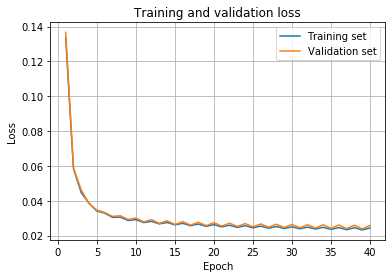

In [41]:
view_results.accvsepoch(t_error[::30], v_error[::30])

## storing a copy of learned weights in hard drive

In [33]:
writer = SummaryWriter()
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()